# Retention curve

This notebook should be used to plot retention curves for users. You shoud have users history for DAYS days with at least 2 events = one to detect user's activity ("active") in app and another one ("first_open") to detect first users appear in app.
At any time you will see share of users which will have activity in next DAYS in the app.
In this example you will train at users with usage history 20 days.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt

sns.set()


Data download and preprocessing - new time and data columns, processing  timezone.

In [2]:
DAYS = 5
df = pd.read_csv("user_data_example.csv")


In [3]:
df.reset_index(drop=True, inplace=True)
time = (df['event_timestamp'] / (1000000.)).apply(datetime.datetime.fromtimestamp)
hour_time = time.apply(lambda x: x.replace(microsecond=0, second=0, minute=0))
df['date_hour'] = hour_time
df['date_hour'] = df['date_hour'] + datetime.timedelta(hours=3)


In [4]:
date_tab = df['date_hour'].apply(datetime.datetime.date)
df['date'] = date_tab


Group usage by hours and dates.

In [5]:
user_hour = df.groupby(['user_pseudo_id', 'date_hour']).first()
user_hour.reset_index(inplace=True, drop=False)
user_hour.sort_values('date_hour', inplace=True);

users_per_day = df.groupby('user_pseudo_id')['date'].first().reset_index()
users_per_day_total = users_per_day.date.value_counts()


In [8]:
users_per_hour = df.groupby('user_pseudo_id')['date_hour'].first().reset_index()


Select user groups, which download app in certain date (determine by event = first_open)

You can select how do you want to group users - by hours or by date

In [23]:
#dates = users_per_day.date.unique()
dates = users_per_hour.date_hour.unique()
dates.sort()


In [15]:
users_download = pd.DataFrame([])
for t in (dates):
    users_download_ = (df[(df['event_name'] == 'first_open') & (df['date_hour'] == t)]. \
        drop_duplicates('user_pseudo_id')['user_pseudo_id']).reset_index(drop=True)
    users_download = pd.concat([users_download, users_download_], axis=1, sort=False, ignore_index=True)


Create tables to save results

In [18]:
start_date = user_hour['date_hour'].min()
end_date = user_hour['date_hour'].max()

total_hours = (end_date - start_date).total_seconds() // 3600
delta_hours = []

for t in range(int(total_hours) + 1):
    delta_hours.append(start_date + t * datetime.timedelta(hours=1))
for t in range(len(dates)):
    dates[t] = pd.Timestamp(dates[t])


Calculate retention curves for different users cohorts.

In [19]:
df_users_events = pd.DataFrame(columns=dates, index=delta_hours)


In [57]:
for n in range(len(dates)):
    df_1day_users = user_hour[user_hour['user_pseudo_id'].isin(users_download.iloc[:, n].dropna())]
    num_users = []
    df_1day_users = df_1day_users.drop(df_1day_users[(df_1day_users['date_hour'] < pd.to_datetime(dates[n]))].index)
    df_1day_users = df_1day_users.drop(
        df_1day_users[(df_1day_users['date_hour'] > (pd.to_datetime(dates[n]) + datetime.timedelta(days=DAYS)))].index)
    for t in (delta_hours):
        users_each_day = df_1day_users[((df_1day_users['date_hour'] > t))].drop_duplicates('user_pseudo_id')
        users_each_day = users_each_day['user_pseudo_id'].reset_index(drop=True)
        num_users.append(len(users_each_day))
    df_users_events.iloc[:, n] = num_users


Create table to allign users data

In [71]:
df_users_events = df_users_events.iloc[:, 1:]


In [72]:
y = df_users_events.iloc[:, :].copy()
y.reset_index(inplace=True, drop=True);
y[:] = 0


In [74]:
for k in range(df_users_events.shape[1]):
    y.iloc[:, k] = df_users_events.iloc[k:, k].reset_index(drop=True)


In [77]:
for k in range(df_users_events.shape[1]):
    y.iloc[:, k] = y.iloc[:, k] / y.iloc[:, k].max()


Plot retention curve

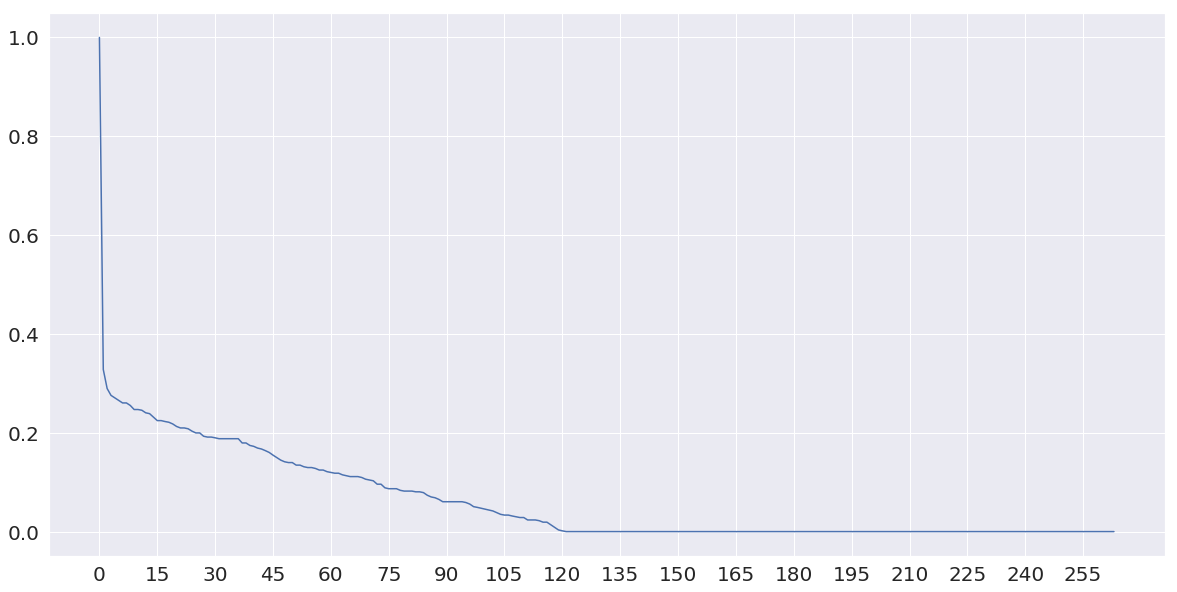

In [78]:
y = y.iloc[:,0:DAYS].apply(np.mean,axis = 1)
x = np.arange(len(y));
mpl.rc('xtick', labelsize=20);
mpl.rc('ytick', labelsize=20);

plt.figure(figsize=(20,10));

plt.plot(x, y)
plt.xticks(np.arange(0, len(y), step=15));